# GTD: Global Terrorism Database



As is explained in the text file presented, GTD  is an open-source database that includes information on terrorist events around the world from 1970 through 2017.




Through this notebook, will be possible to follow the different data preparations and statistics needed for a correct pre-analysis. Moreover, is presented the complete development and the investigations of the different models prepared with STAN. 

For the creation of the models, a correct data preparation is needed. Having 135 different attributes in the dataset, most of them categorical, could easily ends in more than 1000, something impossible (or at least endless) to compute for STAN. For this reason, there have been two steps in the selection of the data:

* A first selection of the attributes for formulating the Research question. So many attributes give a good overview, but does not help to find a concrete question. As the intention is not creating a program with word analysis but a model that recieves numerical data, label and text attributes have been deleted.

* After having the research question, the attributes will be reduced as much as possible to be able (in terms of time) to investigate the models. 



## 1. First Data analysis and pre-preparation

For the creation of the models, a correct data preparation is needed. Having 135 different attributes in the dataset, most of them categorical, could easily ends in more than 1000, something impossible (or at least endless) to compute for STAN. For this reason, there have been two steps in the selection of the data:

* A first selection of the attributes for formulating the Research question. So many attributes give a good overview, but does not help to find a concrete question. As the intention is not creating a program with word analysis but a model that recieves numerical data, label and text attributes have been deleted.

* After having the research question, the attributes will be reduced as much as possible to be able (in terms of time) to investigate the models. 


## 1. Imports

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn import preprocessing
import scipy.sparse as sparse
import gc
gc.collect()
import seaborn as sns
import pystan
#import pystan_utils
from sklearn import linear_model
import pystan
#import pystan_utils
import math

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)


In [5]:
# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [92]:
df = pd.read_csv('Data_original.csv', ';', encoding='latin1')

In [94]:
df['location']

0                                                       NaN
1                                                       NaN
2                                                       NaN
3                                                       NaN
4                                                       NaN
                                ...                        
181686       The incident occurred near the town of Balcad.
181687       The incident occurred at the Humaymim Airport.
181688    The incident occurred in the Datu Hoffer distr...
181689    The incident occurred in the Mantripukhri neig...
181690                                                  NaN
Name: location, Length: 181691, dtype: object

### 2. First drop

The function of the next coding lines is the elimination of the columns that are not very relevant for a future research question:

In [50]:
columns_dataset=len(df.columns)
print('The number of columns in the dataset is %d' % columns_dataset)

print('Before dropping "doubtterr" is configured that the attacks are confirmed terrorist attacks, so "doubtterr"=0')


df = df[df.doubtterr==0]

df = df.reset_index()
del df['index']

drops = ['eventid','approxdate','resolution','provstate', 'specificity',
         'vicinity','location','summary','alternative','alternative_txt',
         'multiple','success','suicide','corp1','target1','natlty1','doubtterr',
         'natlty1_txt','corp2','target2','natlty2',
         'natlty2_txt','corp3','target3','natlty3','natlty3_txt',
         'motive','guncertain1','guncertain2','guncertain3','individual',
         'claimed','claimmode','claimmode_txt','claim2','claimmode2','claimmode2_txt','claim3','claimmode3',
         'claimmode3_txt','compclaim','weapdetail','nkillus','nwoundus',
         'nwoundte','property','propextent','propextent_txt','propvalue','propcomment',
         'ishostkid','nhostkid','nhostkidus','nhours','ndays','divert','kidhijcountry','ransom','ransomamt',
         'ransomamtus','ransompaid','ransompaidus','ransomnote','hostkidoutcome','hostkidoutcome_txt',
         'nreleased','addnotes','scite1','scite2','scite3','dbsource','INT_LOG','INT_IDEO','INT_MISC',
         'INT_ANY','related']

df = df.drop(drops, axis=1)
df = df.reset_index()
del df['index']

columns_dataset=len(df.columns)

print('The number of columns in the dataset is %d' % columns_dataset)

The number of columns in the dataset is 135
Before dropping "doubtterr" is configured that the attacks are confirmed terrorist attacks, so "doubtterr"=0
The number of columns in the dataset is 59


This modification, will lead to a dataset of terrorist attacks where the following aspects are informed:

* Where
* When
* Different criteria for the attack
* Target
* Nº killed/wounded people
* Type of attack
* Type of weapons used
* Organization involved
* Nº of perpetrators/killed/captured

At this point, we thought about the possibility of classification of attacks in organizations, forecast possible attacks, give estimations of unknown data that could be useful for the strategy to follow during a terrorist attack (f.e: if the police cannot see inside a building, which kind of guns are more likely used by the hijackers?). At the end we decided to focus on creating an action-strategy for different possible scenarios. Thinking about how to help in a real-case world we have decided that our research question will be:

##### Number of possible wounded people in a terrorist attack, to provide a good, fast and efficient medical service and mobilization

Hospitals and medical services is one of the most important things in a terrorist attacks and our intention is to create a real output for them, as soon as they receive the information of the police agents.

### 3. Second drop

As the main point of this project is to provide a service when an attack occurs, we want to evaluate the attacks that do not extend for more than a day, because the service would be different and could bias our data. The next coding lines are for setting that *extended* attribute according to this target.

In [51]:
print('Before setting the extende attribute the number of attacks in the dataset is %d' % df.shape[0])
df = df[df.extended==0]
df = df.reset_index()
del df['index']

print('After setting the extende attribute the number of attacks in the dataset is %d' % df.shape[0])

extended_drops = ['extended']

df = df.drop(extended_drops, axis=1)
df = df.reset_index()
del df['index']

Before setting the extende attribute the number of attacks in the dataset is 138905
After setting the extende attribute the number of attacks in the dataset is 131966


The amount of attributes is still huge. We will analyze the possibility of removing the subtypes:

In [52]:
subtypes= len(df['targsubtype1'].unique())
print('There are %d possible target subtypes' % subtypes)

There are 113 possible target subtypes


Having that many possiblities for each of the main categorical attributes (weapon, attack and target) does not help at all to analyse the problem in a overall view. For this reason, all the subtypes are discarded.

In [53]:
subtypes = ['targsubtype1','targsubtype1_txt','targsubtype2','targsubtype2_txt','targsubtype3','targsubtype3_txt','gsubname','gsubname2',
            'gsubname3','weapsubtype1','weapsubtype1_txt','weapsubtype2','weapsubtype2_txt','weapsubtype3',
            'weapsubtype3_txt','weapsubtype4','weapsubtype4_txt']

df = df.drop(subtypes, axis=1)
df = df.reset_index()
del df['index']

columns_dataset=len(df.columns)
print('The number of columns in the dataset is %d' % columns_dataset)

The number of columns in the dataset is 41


Then, we can analyze if it worths to keep the information of combination of different organizations, weapons, etc.. : 

In [54]:
print(df['targtype2'].isna().sum())
print(df['attacktype2'].isna().sum())
print(df['weaptype2'].isna().sum())

122950
128100
122807


As we can see, there is a lot of empty values in the dataset, something that would not help at all even if we merge the information when we one-hot encode this data. Therefore, all the type 2 will be deleted.

In [55]:
type2 = ['attacktype2','attacktype2_txt','attacktype3','attacktype3_txt','targtype2','targtype2_txt',
         'targtype3','targtype3_txt','gname2','gname3','weaptype2','weaptype2_txt','weaptype3','weaptype3_txt',
         'weaptype4','weaptype4_txt']

df = df.drop(type2, axis=1)
df = df.reset_index()
del df['index']

columns_dataset=len(df.columns)
print('The number of columns in the dataset is %d' % columns_dataset)

The number of columns in the dataset is 25


The inmense amount of the possibilities (currently 194 different countries and more counting the non-currently-existing countries as URSS) together with the lack of the links between each country could make the algorithm not appreciate the importance of the proximity of them. For this reason, for this project is considered the **region** as our location parameter as we considered that longitude and latitude would be a problem due to its complexity.

In terms of date variables, even though it could be interesting, having the concrete _day_ and _month_ would not be as representative as having the **year**, and is the reason why we keep it as our date variable.

In [56]:
date_location_drops = ['iday','imonth','country','country_txt','longitude','latitude']

df = df.drop(date_location_drops, axis=1)
df = df.reset_index()
del df['index']

columns_dataset=len(df.columns)
print('The number of columns in the dataset is %d' % columns_dataset)

The number of columns in the dataset is 19


In [57]:
terrorist_orgs= len(df['gname'].unique())
print('There are %d possible terrorist organizations' % terrorist_orgs)

There are 2960 possible terrorist organizations


The terrorist organizations, after the one-hot encoding, would lead to 3537 new attributes and is discarded because the difficulty of compute such amount of data. For reducing as well the rows, is decided to choose the most frequent (20) organizations(Unknown value not considered).

In [58]:
temp = df.gname.value_counts()
print(temp.head(21))

Unknown                                             59953
Taliban                                              5675
Shining Path (SL)                                    4105
Islamic State of Iraq and the Levant (ISIL)          4007
Farabundo Marti National Liberation Front (FMLN)     2117
Boko Haram                                           1997
Irish Republican Army (IRA)                          1873
Basque Fatherland and Freedom (ETA)                  1868
Al-Shabaab                                           1866
Revolutionary Armed Forces of Colombia (FARC)        1832
New People's Army (NPA)                              1753
Communist Party of India - Maoist (CPI-Maoist)       1625
Kurdistan Workers' Party (PKK)                       1499
Maoists                                              1389
National Liberation Army of Colombia (ELN)           1146
Liberation Tigers of Tamil Eelam (LTTE)              1072
Tehrik-i-Taliban Pakistan (TTP)                      1002
Manuel Rodrigu

In [59]:
df_gname1 = df[df.gname=="Taliban"]
df_gname1 = df_gname1.reset_index()
del df_gname1['index']

In [60]:
df_gname2 = df[df.gname=="Islamic State of Iraq and the Levant (ISIL)"]
df_gname2 = df_gname2.reset_index()
del df_gname2['index']
df1 = pd.concat([df_gname1,df_gname2])
df1 = df1.reset_index()
del df1['index']

In [61]:
df_gname3 = df[df.gname=="Shining Path (SL)"]
df_gname3 = df_gname3.reset_index()
del df_gname3['index']
df1 = pd.concat([df1,df_gname3])
df1 = df1.reset_index()
del df1['index']

In [62]:
df_gname4 = df[df.gname=="Boko Haram"]
df_gname4 = df_gname4.reset_index()
del df_gname4['index']
df1 = pd.concat([df1,df_gname4])
df1 = df1.reset_index()
del df1['index']

In [63]:
df_gname5 = df[df.gname=="Farabundo Marti National Liberation Front (FMLN)"]
df_gname5 = df_gname5.reset_index()
del df_gname5['index']
df1 = pd.concat([df1,df_gname5])
df1 = df1.reset_index()
del df1['index']

In [64]:
df_gname6 = df[df.gname=="Al-Shabaab"]
df_gname6 = df_gname6.reset_index()
del df_gname6['index']
df1 = pd.concat([df1,df_gname6])
df1 = df1.reset_index()
del df1['index']

In [65]:
df_gname7 = df[df.gname=="Revolutionary Armed Forces of Colombia (FARC)"]
df_gname7 = df_gname7.reset_index()
del df_gname7['index']
df1 = pd.concat([df1,df_gname7])
df1 = df1.reset_index()
del df1['index']

In [66]:
df_gname8 = df[df.gname=="Basque Fatherland and Freedom (ETA)"]
df_gname8 = df_gname8.reset_index()
del df_gname8['index']
df1 = pd.concat([df1,df_gname8])
df1 = df1.reset_index()
del df1['index']

In [67]:
df_gname9 = df[df.gname=="Irish Republican Army (IRA)"]
df_gname9 = df_gname9.reset_index()
del df_gname9['index']
df1 = pd.concat([df1,df_gname9])
df1 = df1.reset_index()
del df1['index']

In [68]:
df_gname10 = df[df.gname=="New People's Army (NPA)"]
df_gname10 = df_gname10.reset_index()
del df_gname10['index']
df1 = pd.concat([df1,df_gname10])
df1 = df1.reset_index()
del df1['index']

In [69]:
df_gname11= df[df.gname=="Communist Party of India - Maoist (CPI-Maoist)"]
df_gname11 = df_gname11.reset_index()
del df_gname11['index']
df1 = pd.concat([df1,df_gname11])
df1 = df1.reset_index()
del df1['index']

In [70]:
df_gname12 = df[df.gname=="Kurdistan Workers' Party (PKK)"]
df_gname12 = df_gname12.reset_index()
del df_gname12['index']
df1 = pd.concat([df1,df_gname12])
df1 = df1.reset_index()
del df1['index']

In [71]:
df_gname13 = df[df.gname=="Maoists"]
df_gname13 = df_gname13.reset_index()
del df_gname13['index']
df1 = pd.concat([df1,df_gname13])
df1 = df1.reset_index()
del df1['index']

In [72]:
df_gname14 = df[df.gname=="National Liberation Army of Colombia (ELN)"]
df_gname14 = df_gname14.reset_index()
del df_gname14['index']
df1 = pd.concat([df1,df_gname14])
df1 = df1.reset_index()
del df1['index']

In [73]:
df_gname15 = df[df.gname=="Tehrik-i-Taliban Pakistan (TTP)"]
df_gname15 = df_gname15.reset_index()
del df_gname15['index']
df1 = pd.concat([df1,df_gname15])
df1 = df1.reset_index()
del df1['index']

In [74]:
df_gname16 = df[df.gname=="Liberation Tigers of Tamil Eelam (LTTE)"]
df_gname16 = df_gname16.reset_index()
del df_gname16['index']
df1 = pd.concat([df1,df_gname16])
df1 = df1.reset_index()
del df1['index']

In [75]:
df_gname17 = df[df.gname=="Houthi extremists (Ansar Allah)"]
df_gname17 = df_gname17.reset_index()
del df_gname17['index']
df1 = pd.concat([df1,df_gname17])
df1 = df1.reset_index()
del df1['index']

In [76]:
df_gname18 = df[df.gname=="Manuel Rodriguez Patriotic Front (FPMR)"]
df_gname18 = df_gname18.reset_index()
del df_gname18['index']
df1 = pd.concat([df1,df_gname18])
df1 = df1.reset_index()
del df1['index']

In [77]:
df_gname19 = df[df.gname=="Corsican National Liberation Front (FLNC)"]
df_gname19 = df_gname19.reset_index()
del df_gname19['index']
df1 = pd.concat([df1,df_gname19])
df1 = df1.reset_index()
del df1['index']

In [78]:
df_gname20 = df[df.gname=="Al-Qaida in the Arabian Peninsula (AQAP)"]
df_gname20 = df_gname20.reset_index()
del df_gname20['index']
df1 = pd.concat([df1,df_gname20])
df1 = df1.reset_index()
del df1['index']

In [79]:
df1.sort_values(['iyear'],ascending=True)
print(df1.shape)

(37468, 19)


In [80]:
gname_drops = ['gname']

df1 = df1.drop(gname_drops, axis=1)
df1 = df1.reset_index()
del df1['index']

columns_dataset=len(df1.columns)
print('The number of columns in the dataset is %d' % columns_dataset)

The number of columns in the dataset is 18


In [81]:
print(df1.head(0))

Empty DataFrame
Columns: [iyear, region, region_txt, city, crit1, crit2, crit3, attacktype1, attacktype1_txt, targtype1, targtype1_txt, nperps, nperpcap, weaptype1, weaptype1_txt, nkill, nkillter, nwound]
Index: []


At this point, all the interesting variables for the project. Therefore, we should do a data quality check for seeing if we can still reduce our dataset by attributes with a big amount of empty values or 'Unknown' values of them. 

In [82]:
print('The attribute iyear has %d empty records' %df1['iyear'].isna().sum())
print('The attribute region has %d empty records' %df1['region'].isna().sum())
print('The attribute crit1 has %d empty records' %df1['crit1'].isna().sum())
print('The attribute crit2 has %d empty records' %df1['crit2'].isna().sum())
print('The attribute crit3 has %d empty records' %df1['crit3'].isna().sum())
print('The attribute attacktype1 has %d empty records' %df1['attacktype1'].isna().sum())
print('The attribute targtype1 has %d empty records' %df1['targtype1'].isna().sum())
print('The attribute nperps has %d empty records' %df1['nperps'].isna().sum())
print('The attribute nperpcap has %d empty records' %df1['nperpcap'].isna().sum())
print('The attribute weaptype1 has %d empty records' %df1['weaptype1'].isna().sum())
print('The attribute nkill has %d empty records' %df1['nkill'].isna().sum())
print('The attribute nkillter has %d empty records' %df1['nkillter'].isna().sum())
print('The attribute nwound has %d empty records' %df1['nwound'].isna().sum())

The attribute iyear has 0 empty records
The attribute region has 0 empty records
The attribute crit1 has 0 empty records
The attribute crit2 has 0 empty records
The attribute crit3 has 0 empty records
The attribute attacktype1 has 0 empty records
The attribute targtype1 has 0 empty records
The attribute nperps has 14155 empty records
The attribute nperpcap has 14815 empty records
The attribute weaptype1 has 0 empty records
The attribute nkill has 2046 empty records
The attribute nkillter has 14759 empty records
The attribute nwound has 3465 empty records


Because of the big amount of empty values in the number of perpetrators (*nperps*), number of perpetrators captured (*nperpscap*) and number of killed terrorist (*nkillterr*), those attributes will be removed for improve the quality of the inputs.

In [83]:
empty_drops = ['nkillter','nperps','nperpcap']

df1 = df1.drop(empty_drops, axis=1)
df1 = df1.reset_index()
del df1['index']

columns_dataset=len(df1.columns)
print('The number of columns in the dataset is %d' % columns_dataset)


The number of columns in the dataset is 15


In [84]:
print(df1.head(0))


Empty DataFrame
Columns: [iyear, region, region_txt, city, crit1, crit2, crit3, attacktype1, attacktype1_txt, targtype1, targtype1_txt, weaptype1, weaptype1_txt, nkill, nwound]
Index: []


In [85]:
print('The attribute iyear has %d empty records' %df1['iyear'].isna().sum())
print('The attribute region has %d empty records' %df1['region'].isna().sum())
print('The attribute crit1 has %d empty records' %df1['crit1'].isna().sum())
print('The attribute crit2 has %d empty records' %df1['crit2'].isna().sum())
print('The attribute crit3 has %d empty records' %df1['crit3'].isna().sum())
print('The attribute attacktype1 has %d empty records' %df1['attacktype1'].isna().sum())
print('The attribute targtype1 has %d empty records' %df1['targtype1'].isna().sum())
print('The attribute weaptype1 has %d empty records' %df1['weaptype1'].isna().sum())
print('The attribute nkill has %d empty records' %df1['nkill'].isna().sum())
print('The attribute nwound has %d empty records' %df1['nwound'].isna().sum())

The attribute iyear has 0 empty records
The attribute region has 0 empty records
The attribute crit1 has 0 empty records
The attribute crit2 has 0 empty records
The attribute crit3 has 0 empty records
The attribute attacktype1 has 0 empty records
The attribute targtype1 has 0 empty records
The attribute weaptype1 has 0 empty records
The attribute nkill has 2046 empty records
The attribute nwound has 3465 empty records


Weapon type, attack type and target types are attributes that has the possibility of having an unkwnown value. As we considered that is more interesting having specific data, we have decidided to delete the attacks that have at least one "unknown value in those columns.


In [86]:
print('Before deleting the unknown values of these attributes the number of attacks in the dataset is %d' % df1.shape[0])

df1 = df1[df1.weaptype1!=13]
df1 = df1[df1.attacktype1!=9]
df1 = df1[df1.targtype1!=20]

print('After deleting the unknown values of these attributes the number of attacks in the dataset is %d' % df1.shape[0])

df1 = df1.reset_index()
del df1['index']

Before deleting the unknown values of these attributes the number of attacks in the dataset is 37468
After deleting the unknown values of these attributes the number of attacks in the dataset is 33200


##### Deleting NaN records

In [87]:
df1=df1.dropna()

print('After deleting the unknown values of these attributes the number of attacks in the dataset is %d' % df1.shape[0])

After deleting the unknown values of these attributes the number of attacks in the dataset is 30070


In [88]:
print('The attribute iyear has %d empty records' %df1['iyear'].isna().sum())
print('The attribute region has %d empty records' %df1['region'].isna().sum())
print('The attribute crit1 has %d empty records' %df1['crit1'].isna().sum())
print('The attribute crit2 has %d empty records' %df1['crit2'].isna().sum())
print('The attribute crit3 has %d empty records' %df1['crit3'].isna().sum())
print('The attribute attacktype1 has %d empty records' %df1['attacktype1'].isna().sum())
print('The attribute targtype1 has %d empty records' %df1['targtype1'].isna().sum())
print('The attribute weaptype1 has %d empty records' %df1['weaptype1'].isna().sum())
print('The attribute nkill has %d empty records' %df1['nkill'].isna().sum())
print('The attribute nwound has %d empty records' %df1['nwound'].isna().sum())

The attribute iyear has 0 empty records
The attribute region has 0 empty records
The attribute crit1 has 0 empty records
The attribute crit2 has 0 empty records
The attribute crit3 has 0 empty records
The attribute attacktype1 has 0 empty records
The attribute targtype1 has 0 empty records
The attribute weaptype1 has 0 empty records
The attribute nkill has 0 empty records
The attribute nwound has 0 empty records


In [89]:
df1.head()

,iyear,region,region_txt,city,crit1,crit2,crit3,attacktype1,attacktype1_txt,targtype1,targtype1_txt,weaptype1,weaptype1_txt,nkill,nwound
0,1995,6,South Asia,Kandahar,1,1,1,4,Hijacking,6,Airports & Aircraft,6,Explosives,0.0,0.0
1,1995,6,South Asia,Kabul,1,1,1,3,Bombing/Explosion,6,Airports & Aircraft,6,Explosives,0.0,0.0
3,2001,6,South Asia,Khodja Baha ud din,1,1,1,3,Bombing/Explosion,2,Government (General),6,Explosives,3.0,1.0
5,2002,6,South Asia,Khost,1,1,1,3,Bombing/Explosion,4,Military,6,Explosives,0.0,4.0
6,2002,6,South Asia,Ghazni,1,1,1,3,Bombing/Explosion,8,Educational Institution,6,Explosives,0.0,0.0


In [90]:
df1.to_csv('data_terr.csv',index=False)


## 3. Data analysis and statistics


At this moment we are prepare for analyze our chosen attributes and create some statistics for helping us to understand them better or to continue modifying the dataset.

### Year: *Iyear*

Text(0.5, 1.0, 'Attacks per year')

<Figure size 3600x720 with 0 Axes>

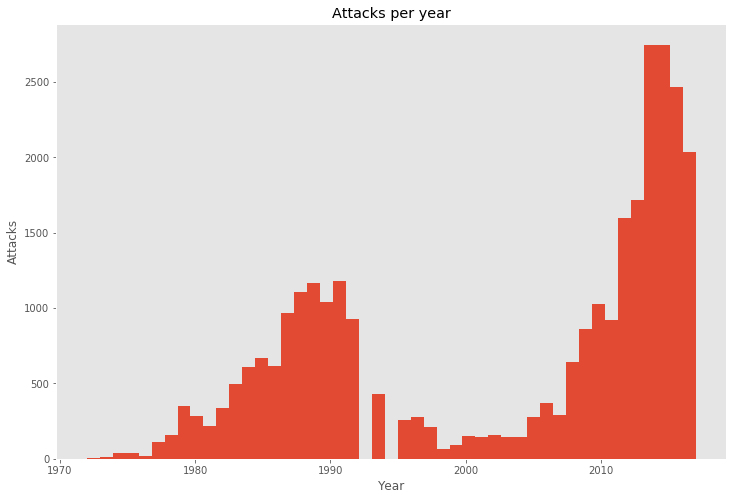

In [235]:
fig = plt.figure(figsize=(50,10))
df1.hist(column='iyear', bins=47, grid=False)
plt.xlabel('Year')
plt.ylabel('Attacks')
plt.title(r'Attacks per year')

From the histogram we can deduce two peaks, with a significative one during the last years. Analyzing its distribution can be said that it follows a combination of a Normal + exponential distribution. It is specially significative how the terrorist world changes after the attack of the Twin Towers. Moreover, is really significative the first peak, with shows the outbreak of several civil wars as the Somalian, Sierra-Leonean.. the conflicts in Eastern Europe in the Yugoslavian contries or the First Gulf War.

### Number of killed people: *Nkill*

Text(0.5, 1.0, 'Zoom in histogram of frequency of killed people in attacks')

<Figure size 3600x720 with 0 Axes>

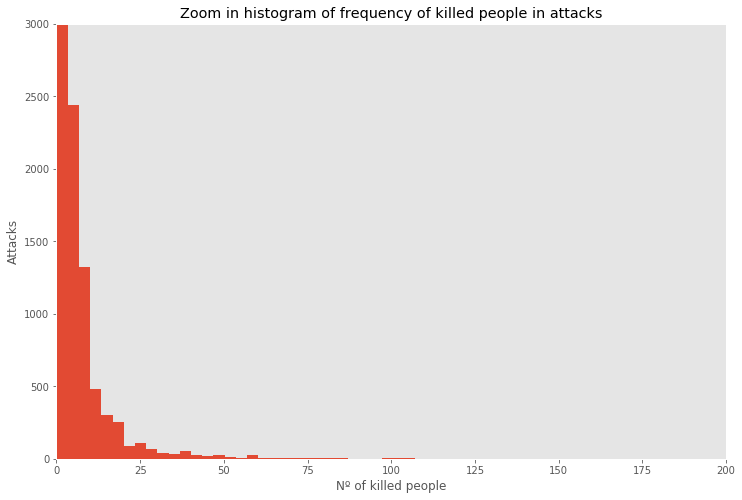

In [236]:
fig = plt.figure(figsize=(50,10))
df1.hist(column='nkill',bins=200, grid=False)
plt.xlim(right = 200)
plt.xlim(left = 0)
plt.ylim(top = 3000)
plt.xlabel('Nº of killed people')
plt.ylabel('Attacks')
plt.title(r'Zoom in histogram of frequency of killed people in attacks')

Text(0.5, 1.0, 'Nº of killed people per attack')

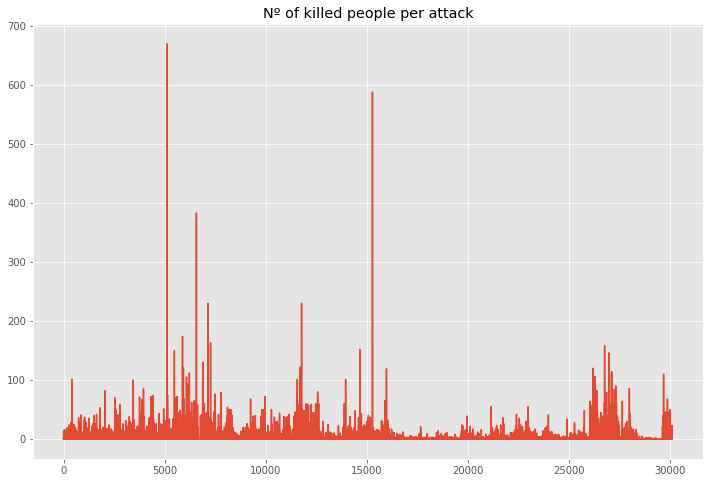

In [238]:
plt.plot(df1['nkill'].values)
plt.title('Nº of killed people per attack')

Almost all the data is concentrated in low number of killed as it is normal, because there are more attacks in which the target was just and individual or a small group. Big actions not happen as usual as the small ones.

### Location: *Region*

Text(0.5, 1.0, '% of attacks by Region - Top 7')

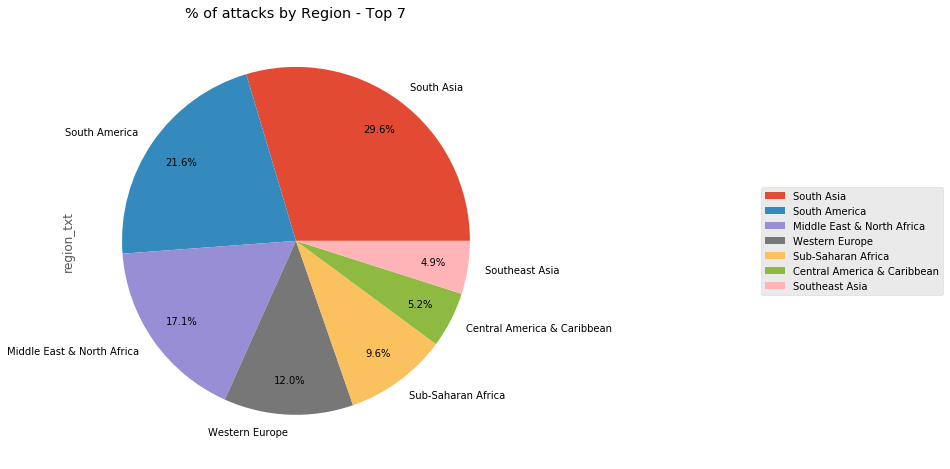

In [239]:
temp = df1.region_txt.value_counts()
temp.head(7).plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of attacks by Region - Top 7')

In [240]:
print('There possible regions are:')
print(df1['region_txt'].unique())
regions= len(df1['region'].unique())
print('There are %d possible regions' % regions)

There possible regions are:
['South Asia' 'Middle East & North Africa' 'Western Europe'
 'Sub-Saharan Africa' 'Southeast Asia' 'Eastern Europe'
 'Australasia & Oceania' 'South America' 'North America'
 'Central America & Caribbean']
There are 10 possible regions


As it was expected, the main regions for terrorist attacks are South Asia, South America and Middle East & North Africa. For understanding why the last one as well as other African regions is needed to say that at this point it has arrived only completed data, when in this places normally is not informed as detailed as in Western Europe.

### Weapon type: *Weaptype1*

Text(0.5, 1.0, '% of attacks by Weapon - Top 5')

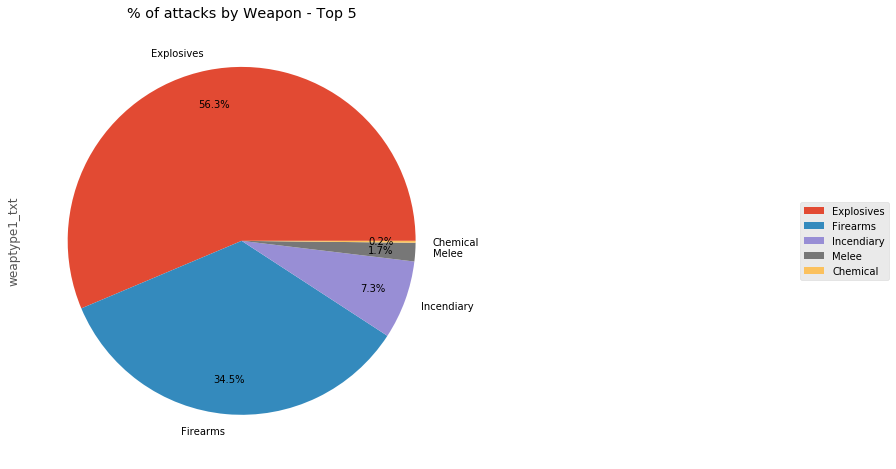

In [241]:
temp = df1.weaptype1_txt.value_counts()
temp.head(5).plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of attacks by Weapon - Top 5')

In [242]:
print('There possible weapon types are:')
print(df1['weaptype1_txt'].unique())
weapons= len(df1['weaptype1'].unique())
print('There are %d possible types of weapon' % weapons)

There possible weapon types are:
['Explosives' 'Firearms' 'Incendiary' 'Melee' 'Radiological'
 'Sabotage Equipment' 'Chemical' 'Other'
 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)']
There are 9 possible types of weapon


Even though the amount of all the small terrorist attacks with firearms involved, explosive-attacks take the lead as the most common one. In this case, as we have been selected that it must be clear that it is without any doubt a terrorist attack, we guarantee the absence of bias in this concrete aspect. 

### Attack type: *Attacktype1*

Text(0.5, 1.0, '% of attacks by type of attack - Top 5')

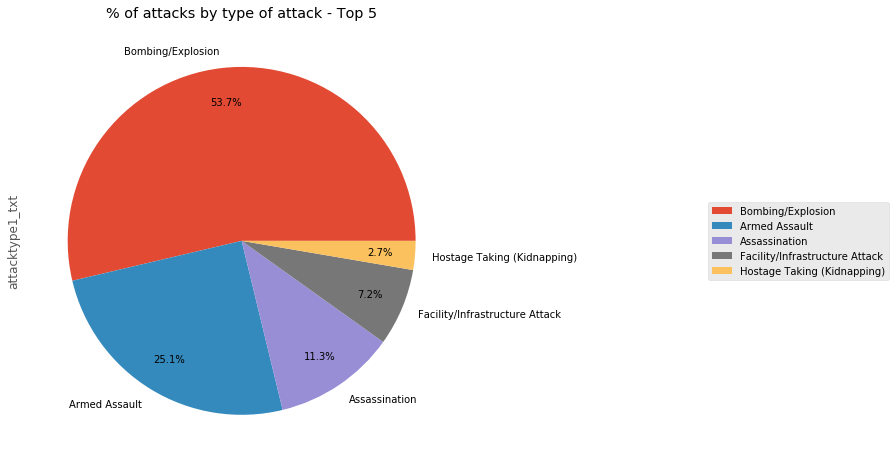

In [243]:
temp = df1.attacktype1_txt.value_counts()
temp.head(5).plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of attacks by type of attack - Top 5')

In [244]:
print('There possible attack types are:')
print(df1['attacktype1_txt'].unique())
types= len(df1['attacktype1'].unique())
print('There are %d possible types of attack' % types)

There possible attack types are:
['Hijacking' 'Bombing/Explosion' 'Assassination' 'Armed Assault'
 'Facility/Infrastructure Attack' 'Hostage Taking (Kidnapping)'
 'Unarmed Assault' 'Hostage Taking (Barricade Incident)']
There are 8 possible types of attack


Here is evident the correlation with the previous attribure *Weapon type* as practically the 50% of the amount of the attacks are Bombing/Explosion ones

### Target Type: *Targtype1*

Text(0.5, 1.0, '% of attacks by type of target - Top 9')

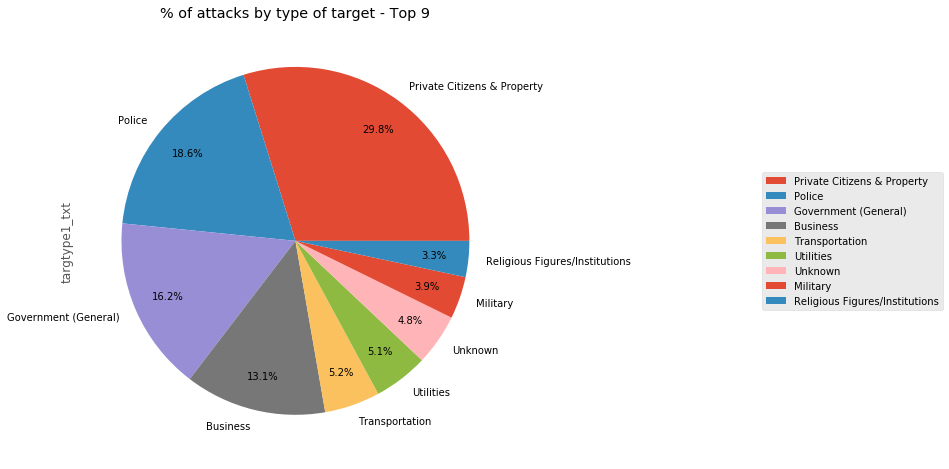

In [246]:
temp = df.targtype1_txt.value_counts()
temp.head(9).plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of attacks by type of target - Top 9')

In [248]:
print('There possible attack types are:')
print(df['targtype1_txt'].unique())
targets= len(df['targtype1'].unique())
print('There are %d possible kinds of target' % targets)

There possible attack types are:
['Private Citizens & Property' 'Government (Diplomatic)'
 'Journalists & Media' 'Police' 'Military' 'Government (General)'
 'Educational Institution' 'Business' 'Violent Political Party' 'Unknown'
 'Transportation' 'Utilities' 'Airports & Aircraft'
 'Religious Figures/Institutions' 'Telecommunication'
 'Food or Water Supply' 'NGO' 'Terrorists/Non-State Militia' 'Other'
 'Tourists' 'Maritime' 'Abortion Related']
There are 22 possible kinds of target


In this case, the most surprising data is that the military target only are the 5% of the attacks. It is beyond our reach knowing if it because the normal confidentiality or if it is about the interests of the terrorist with the Citizens or the impact about attacking targets related with the power, as Police, Business and Government.

**Sadly, after trying to implement the model to STAN, with this attribute (increase by 20 the number of columns after the one-hot enconding) some of the process took more than 40 minutes due to the low computing capacity. For this reason, even though it has been analyzed, it has been removed before.**

In [86]:
target_drop = ['targtype1', 'targtype1_txt']

df1 = df1.drop(target_drop, axis=1)
df1 = df1.reset_index()
del df1['index']
df1.head(0)

,iyear,region,region_txt,crit1,crit2,crit3,attacktype1,attacktype1_txt,weaptype1,weaptype1_txt,nkill,nwound


### Political, economic, religious or social goal: *Crit1*

Text(0.5, 1.0, 'Crit1 distribution of data')

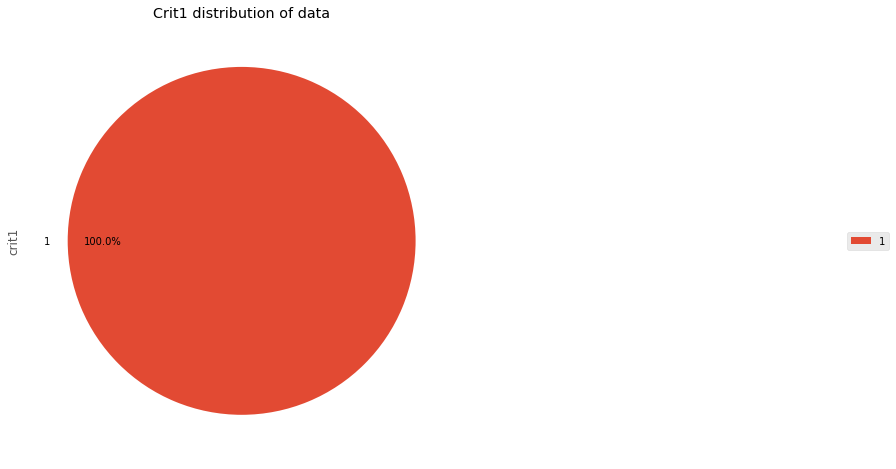

In [249]:
temp = df1.crit1.value_counts()
temp.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('Crit1 distribution of data')

As all the attacks have at least one of the especified goals, the attribute *crit1* is removed as it does not add any value to our dataset.

### Intention to coerce, intimidate or publicize to larger audience(s): *crit2*

Text(0.5, 1.0, 'Crit2 distribution of data')

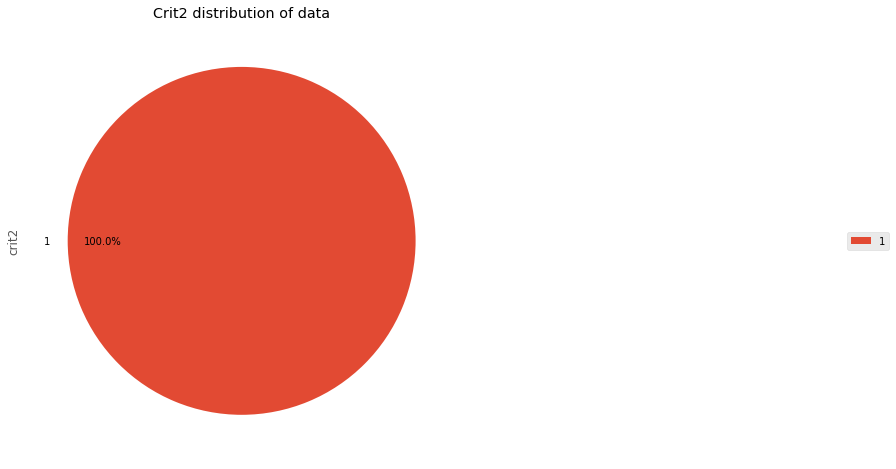

In [250]:
temp = df1.crit2.value_counts()
temp.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('Crit2 distribution of data')

To satisfy this criterion there must be evidence of an intention to coerce, intimidate, or convey some other message to a larger audience (or audiences )than the immediate victims. Such evidence can include (but is not limited to) the following: pre- or post-attack statements by the perpetrator(s), past behavior by the perpetrators, or the particular nature of the target/victim, weapon, or attack type.As all the attacks have at least one of the especified goals, the attribute *crit2* is removed as it does not add any value to our dataset.

### Outside international humanitarian Law: *crit3*

Text(0.5, 1.0, 'Crit3 distribution of data')

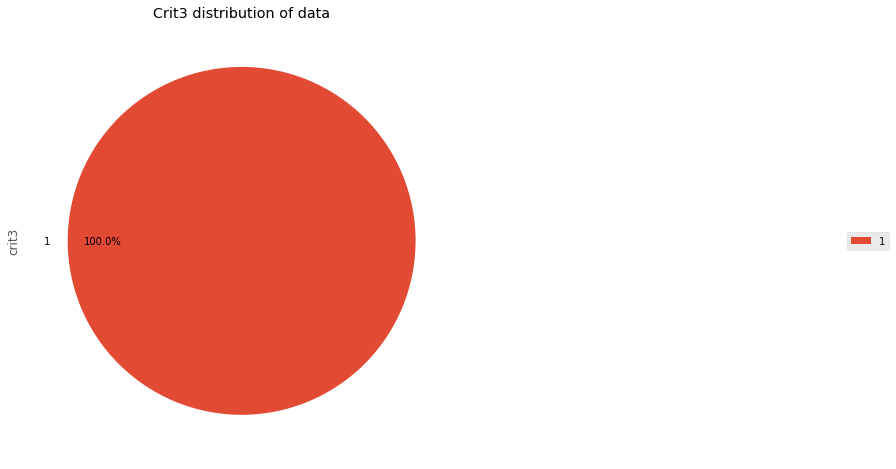

In [251]:
temp = df1.crit3.value_counts()
temp.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8)
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('Crit3 distribution of data')

To satisfy this criterion, the action must be outside the context of legitimate warfare activities, insofar as it targets non-combatants (i.e. the act must be outside the parameters permitted by international humanitarian law as reflected in the Additional Protocol to the Geneva Conventions of 12 August 1949 and elsewhere). As all the attacks have at least one of the especified goals, the attribute *crit3* is removed as it does not add any value to our dataset.

In [87]:
crit_drops = ['crit1', 'crit2', 'crit3']

df_2 = df1.drop(crit_drops, axis=1)
df_2 = df_2.reset_index()
del df_2['index']
df_2.head(0)

,iyear,region,region_txt,attacktype1,attacktype1_txt,weaptype1,weaptype1_txt,nkill,nwound


### Target attribute: Number of wounded people in the attack: *Nwound*

Text(0.5, 1.0, 'Zoom in histogram of wounded people in attacks')

<Figure size 3600x720 with 0 Axes>

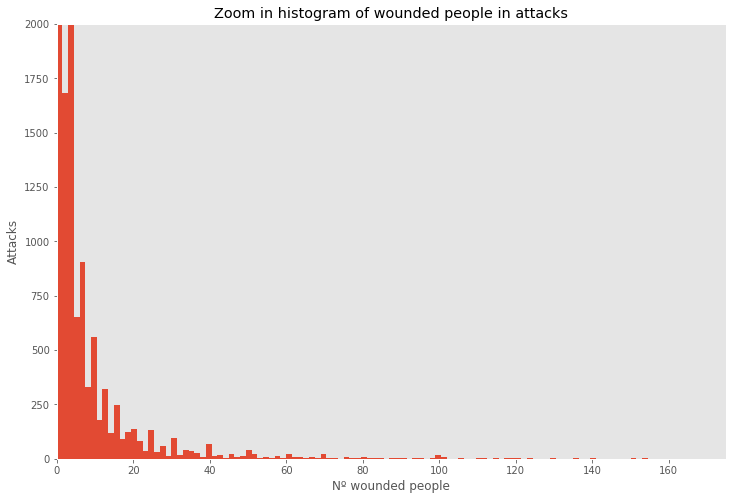

In [252]:
fig = plt.figure(figsize=(50,10))
df1.hist(column='nwound',bins=1000, grid=False)
plt.xlim(right = 175)
plt.xlim(left = 0)
plt.ylim(top = 2000)
plt.xlabel('Nº wounded people')
plt.ylabel('Attacks')
plt.title(r'Zoom in histogram of wounded people in attacks')

Text(0.5, 1.0, 'Nº of killed people per attack')

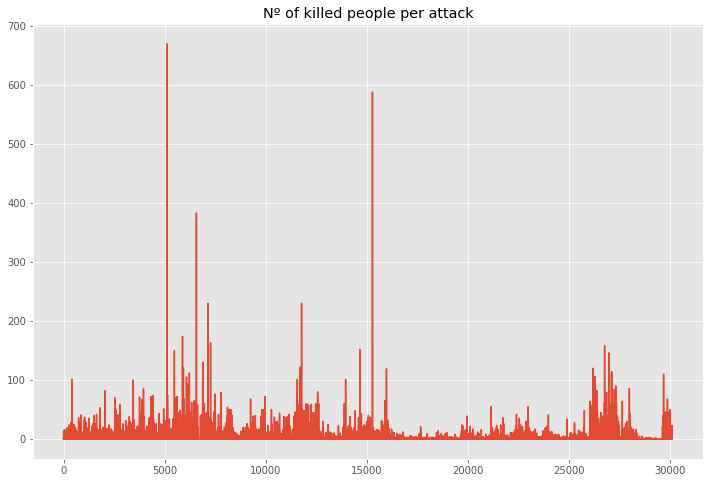

In [253]:
plt.plot(df1['nkill'].values)
plt.title('Nº of killed people per attack')

As we can appreciate in the graphics, *nwound* follows a distribution really similar to a geometric one, something that could be useful afterwards for the analysis. In this case, it is important as well the frequency of a low number of wounded in the attacks. However, there are many attacks in which have been wounded more than one hundred. 

## 3. Combined statistics

### Scatterplot of NKills vs NWounds considering region

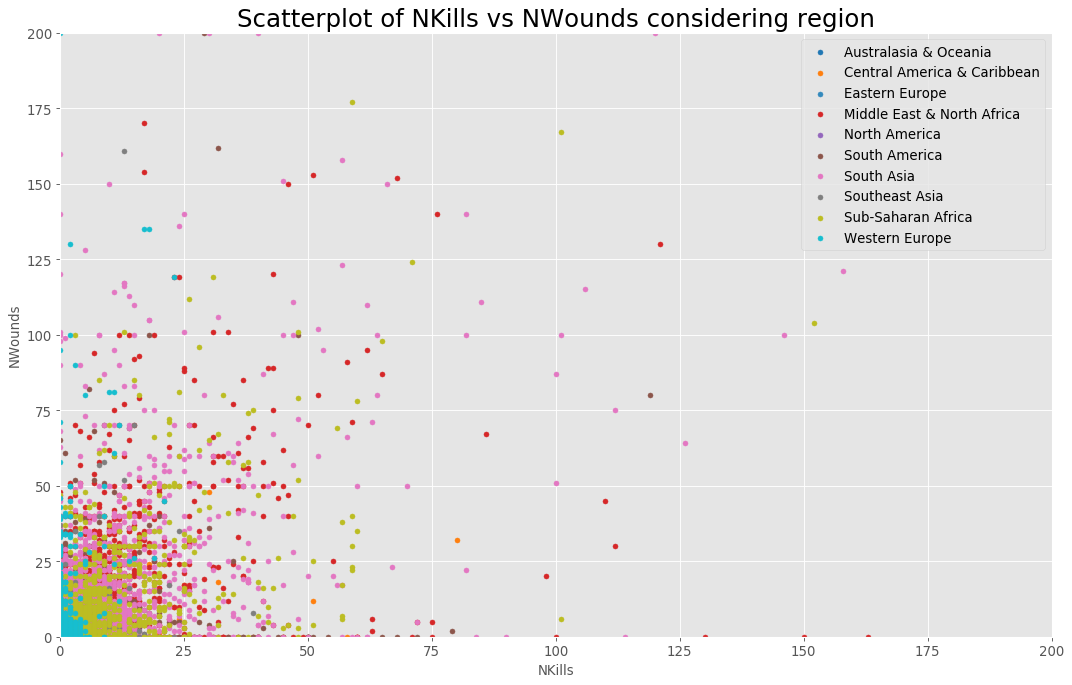

In [254]:
# Prepare Data 
# Create as many colors as there are unique midwest['category']
regions = np.unique(df1['region_txt'])
colors = [plt.cm.tab10(i/float(len(regions)-1)) for i in range(len(regions))]

# Draw Plot for Each Category
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, region in enumerate(regions):
    plt.scatter('nkill', 'nwound', 
                data=df1.loc[df1.region_txt==region, :], 
                s=20, c=colors[i], label=str(region))

# Decorations
plt.gca().set(xlim=(0.0, 200), ylim=(0, 200),
              xlabel='NKills', ylabel='NWounds')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of NKills vs NWounds considering region", fontsize=22)
plt.legend(fontsize=12)    
plt.show() 

It is amazing to see how the terrorist attacks in terms of severity according to the region in which is happening. It is clearly distinguishly how in Europe and North America, the attacks are characterized for low number of wounded and killed people while the numbers increase as we started to move away from both points. Middle east & North Africa and South Asia, on the contrary for high-severity attacks. 

### Scatterplot of NKills vs NWounds considering weapon type

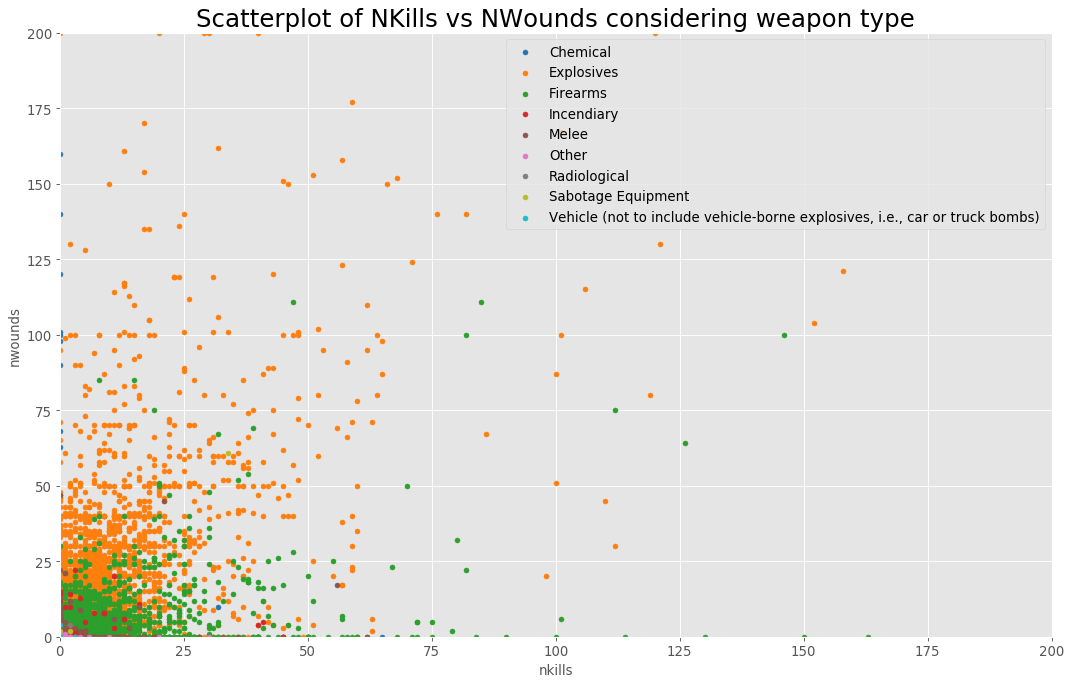

In [255]:
# Prepare Data 
# Create as many colors as there are unique midwest['category']
weapons = np.unique(df1['weaptype1_txt'])
colors = [plt.cm.tab10(i/float(len(weapons)-1)) for i in range(len(weapons))]

# Draw Plot for Each Category
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, weapon in enumerate(weapons):
    plt.scatter('nkill', 'nwound', 
                data=df1.loc[df1.weaptype1_txt==weapon, :], 
                s=20, c=colors[i], label=str(weapon))

# Decorations
plt.gca().set(xlim=(0.0, 200), ylim=(0, 200),
              xlabel='nkills', ylabel='nwounds')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of NKills vs NWounds considering weapon type", fontsize=22)
plt.legend(fontsize=12)    
plt.show() 

In this case, the distribution is following the expecting results. While incendiary attacks usually implies low number of killed but a slightly higher number of wounds, firearms attacks are spreaded between middle numbers of both as an attack with firearms canbe really different between them. Moreover, attacks in which the explosives are involved can be terrible tragedies as is plotted on the graphic.

### Scatterplot of NKills vs NWounds considering attack type

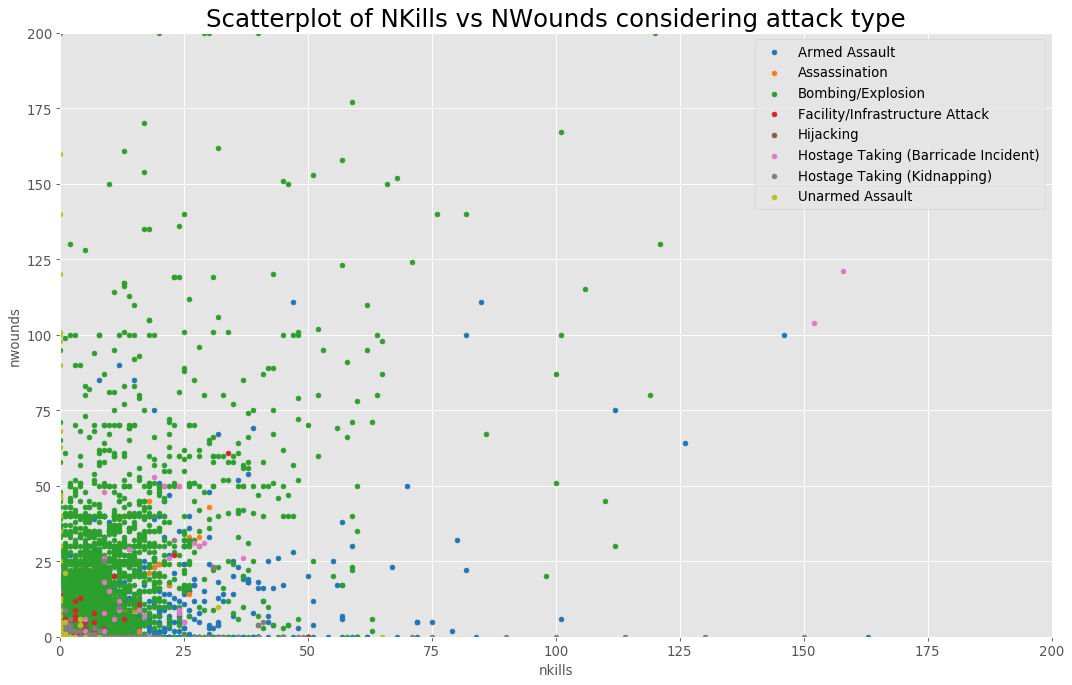

In [256]:
# Prepare Data 
# Create as many colors as there are unique midwest['category']
attacks = np.unique(df1['attacktype1_txt'])
colors = [plt.cm.tab10(i/float(len(weapons)-1)) for i in range(len(weapons))]

# Draw Plot for Each Category
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, attack in enumerate(attacks):
    plt.scatter('nkill', 'nwound', 
                data=df1.loc[df1.attacktype1_txt==attack, :], 
                s=20, c=colors[i], label=str(attack))

# Decorations
plt.gca().set(xlim=(0.0, 200), ylim=(0, 200),
              xlabel='nkills', ylabel='nwounds')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of NKills vs NWounds considering attack type", fontsize=22)
plt.legend(fontsize=12)    
plt.show() 

In this case, the graphic is not clear because of the predominance of the bombing/explosion attacks but shows a high variability in terms of severity of tis kind of attacks.

Text(0.5, 1.0, 'Boxplot of wounded people by attacktype')

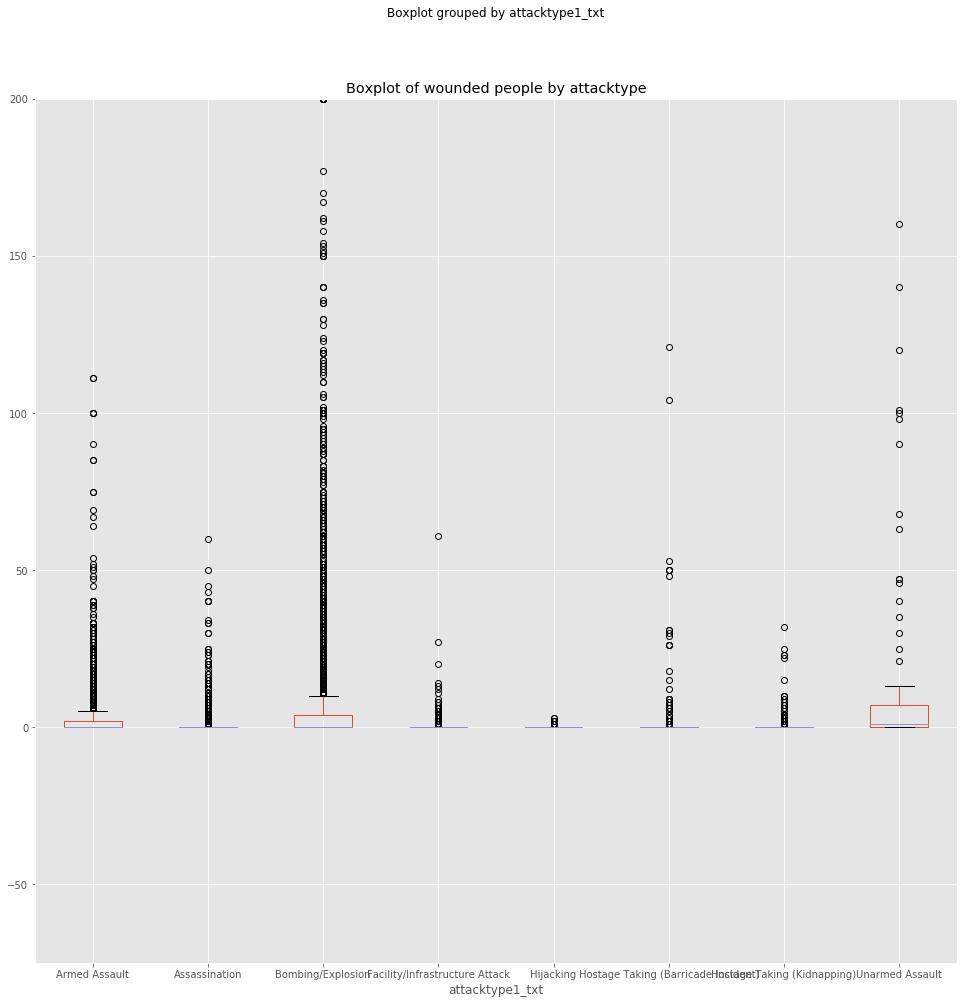

In [257]:
df1.boxplot(column="nwound",        # Column to plot
                 by= "attacktype1_txt",         # Column to split upon
                 figsize= (16,16))
plt.ylim(top = 200)
plt.title('Boxplot of wounded people by attacktype')

With the boxplot is clearer the big variability of our target attribute by the attacktype. In any case, it shows interesting data, for example de lownumber of wounded people when is about a Hijacking hostage, as usually is about of individuals.

### Correlogram of the attributes

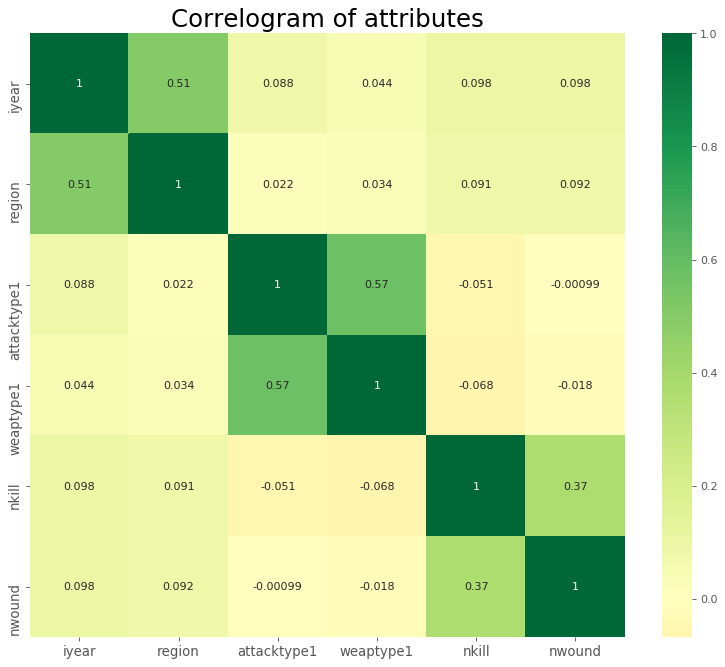

In [266]:
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_2.corr(), xticklabels=df_2.corr().columns, yticklabels=df_2.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of attributes', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

All the selected attributes have been chosen according to our thoughts about what could be interesting and determinant to affect the number our wounded people. However, this matrix shows the correlation between the different attributes. Unfortunately, the relationship between our target attribute with the rest in the dataset is very weak. This scenario, probably will lead into not very useful conclusions.

## 4. Data preparation for STAN

In [89]:
txt_drops = ['attacktype1_txt', 'weaptype1_txt', 'region_txt']

df_notxt = df_2.drop(txt_drops, axis=1)
df_notxt = df_notxt.reset_index()
del df_notxt['index']
df_notxt.head(0)

,iyear,region,attacktype1,weaptype1,nkill,nwound


One of the main aspects of the dataset is the enormous amount of categorical data. These attributes are variables that contain label values rather than numeric values representing to which class it belongs and can be problematic in the classification as they can confuse machine learning algorithms. For this reason the *one hot encoding* is applied in order to solve these problems.


###  One hot encoding

One of the main problems with label encoding is that the algorithms assume: _higher the categorical value, better the category_. One hot encoding allows to "binarize" our categorical data, avoiding this problem and helping the ML creating better predictions. Our different labels from an attribute, becomes after this method a subattribute itself as is explained in the photos:

In [91]:
X_categorical = np.concatenate([pd.get_dummies(df_notxt[x]) for x in ["region", "attacktype1", "weaptype1"]], axis=1)
print(X_categorical.shape)

(30120, 27)


### Standardization X

In [92]:
X_to_standard = df_notxt[["iyear","nkill"]].as_matrix()

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [93]:
# standardize input features
X_mean = X_to_standard.mean(axis=0)
X_std = X_to_standard.std(axis=0)
X_standard = (X_to_standard - X_mean) / X_std
print(X_standard)

[[-0.63229517 -0.2859514 ]
 [-0.63229517 -0.2859514 ]
 [-0.16445955  0.04587811]
 ...
 [ 1.08310212 -0.2859514 ]
 [ 1.08310212 -0.17534157]
 [ 1.08310212  0.26709779]]


### Final matrix X

In [94]:
X = np.concatenate([X_standard, X_categorical], axis=1)
print(X.shape)
#print(X)

(30120, 29)


### Standardization y

In [95]:
y = df_notxt["nwound"].as_matrix()

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [96]:
# standardize nwound
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)
#print(y)

(30120,)


### Train and test

In [106]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 19879
num test: 10241


### Compute_error function

In [98]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

## 5. Models

### 5.1 Linear regression

In [107]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.366
MAE: 4.128
RMSE: 16.628
R2: 0.114


### 5.2 STAN Linear regression with beta

!["titulo"](beta.JPG)

We are using a linear regression model since our target is a quantitative value. We have a dataset consisting of N observations of the targets yn which depend on their corresponding explanatory variables xn, this model finds beta coefficients that best predicts y based on x. 

In [108]:
project_STAN="""
data {
    int<lower=0> N; // number of samples
    int<lower=0> V; // number of predictors
    matrix[N,V] x;  // predictor matrix 
    vector[N] y;    // outcome vector
    
}
parameters {
    vector[V] beta;         // coefficients for predictors
    real<lower=0> sigma;    // error scale
} 
model {
    sigma ~ cauchy(0,10);                        // prior on the variance
    for (v in 1:V)
        beta[v] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(x * beta, sigma);   // likelihood
}
"""

In [109]:
# prepare data for Stan model
N, V = X_train.shape
data = {'N': N, 'V': V, 'x': X_train, 'y': y_train}

In [110]:
%%time
# create Stan model object
# compile model
sm = pystan.StanModel(model_code=project_STAN)
# run inference
fit1 = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08d786c2fcc819e1d1959dbd5d106db8 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp45wp_3wj\stanfit4anon_model_08d786c2fcc819e1d1959dbd5d106db8_3915535160085153842.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\usuario\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 1min 22s


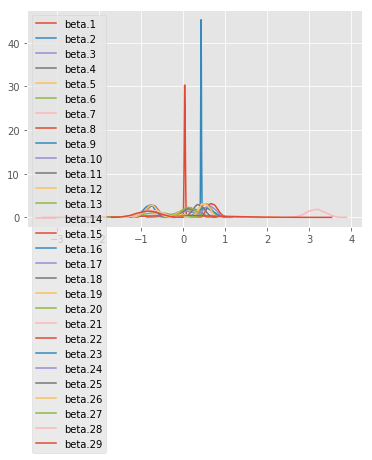

In [111]:
pystan_utils.vb_plot_variables(fit1, "beta")

Betas with very different normal distributions, high values for beta 1 and 2 (year and number of kills) 

In [112]:
beta = pystan_utils.vb_extract_variable(fit1, "beta", var_type="vector")

print("beta:", beta)

beta: [ 0.03577356  0.42449512  0.08650932  0.07771971  0.09004974  0.16738597
  0.16971612  0.16620225 -0.13021136  0.18906303  0.15743911 -0.10036013
  0.55007936  0.48947615  0.69619932  0.5390018   0.63439285  0.37470635
  0.51246486  0.13695009  3.16714393 -0.07195013 -0.80008148 -0.74275058
 -0.72639711 -0.75112079 -0.63225809 -0.7180731  -0.8240699 ]


In [ ]:
pystan_utils.report(fit1, 'beta')

In [113]:
y_hat = np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.366
MAE: 4.145
RMSE: 16.639
R2: 0.113


### 5.2 STAN Linear regression with alpha and beta

!["titulo"](alphabeta.JPG)

We added an error term alpha to account for observation noise.

In [114]:
project_STAN="""
data {
    int<lower=0> N; // number of samples
    int<lower=0> V; // number of predictors
    matrix[N,V] x;  // predictor matrix 
    vector[N] y;    // outcome vector
    
}
parameters {
    real alpha;             // intercept
    vector[V] beta;         // coefficients for predictors
    real<lower=0> sigma;    // error scale
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    sigma ~ cauchy(0,10);                        // prior on the variance
    for (v in 1:V)
        beta[v] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, sigma);   // likelihood
}
"""

In [115]:
# prepare data for Stan model
N, V = X_train.shape
data = {'N': N, 'V': V, 'x': X_train, 'y': y_train}

In [116]:
%%time
# create Stan model object
# compile model
sm = pystan.StanModel(model_code=project_STAN)
# run inference
fit2 = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_afb295b904aaf263614bbb9a36e05015 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmpubmg1zo_\stanfit4anon_model_afb295b904aaf263614bbb9a36e05015_3328018529357901589.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 1min 23s


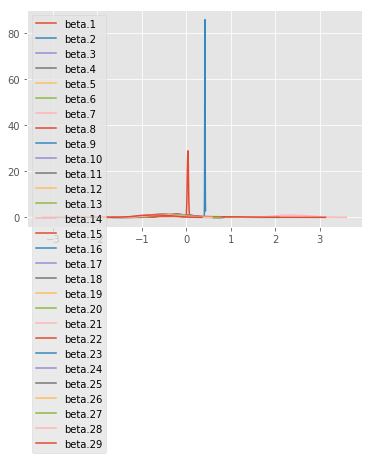

In [117]:
pystan_utils.vb_plot_variables(fit2, "beta")

In [118]:
alpha = pystan_utils.vb_extract_variable(fit2, "alpha", var_type="real")
print("alpha:", alpha)

beta = pystan_utils.vb_extract_variable(fit2, "beta", var_type="vector")
print("beta:", beta)

alpha: 1.109860669498315
beta: [ 0.0345294   0.41857151 -0.2809774  -0.31802907 -0.29845445 -0.23041846
 -0.2261736  -0.22869749 -0.32924778 -0.2034682  -0.23653362 -0.26711571
 -0.3200275  -0.38288605 -0.18167503 -0.3393661  -0.24809059 -0.48700295
 -0.3671963  -0.33339093  2.35148417 -0.06023414 -0.61363938 -0.55611141
 -0.55047572 -0.62308185 -0.55279767 -0.53955606 -0.71513298]


In [ ]:
pystan_utils.report(fit2, 'alpha')
pystan_utils.report(fit2, 'beta')

In [119]:
y_hat = alpha + np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.369
MAE: 4.253
RMSE: 16.572
R2: 0.120


### 5.3 STAN Poisson distribution

!["titulo"](exponential.JPG)

We tried Poisson distribution in order to comprove that actually the attacks don't follow any constant rate.

In [187]:
project_STAN="""
data {
    int<lower=0> N; // number of samples
    int<lower=0> V; // number of predictors
    matrix[N,V] x;  // predictor matrix 
    int y[N];    // outcome vector
    
}
parameters {
    real alpha;             // intercept
    vector[V] beta;         // coefficients for predictors
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    for (v in 1:V)
        beta[v] ~ normal(0,1);             // prior on the coefficients
    y ~ poisson_log(alpha + x * beta);   // likelihood
}
"""

In [188]:
# prepare data for Stan model
N, V = X_train.shape
data = {'N': N, 'V': V, 'x': X_train, 'y': (y_train * y_std + y_mean).astype(np.int)} # y must be original counts

In [189]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit3 = sm.vb(data=data, iter=5000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5637b2aa201e75fb694075cee55443f7 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmpefixbgs9\stanfit4anon_model_5637b2aa201e75fb694075cee55443f7_1386635306595557786.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 11min 32s


In [190]:
alpha = pystan_utils.vb_extract_variable(fit3, "alpha", var_type="real")
beta = pystan_utils.vb_extract_variable(fit3, "beta", var_type="vector")
y_hat = np.exp(alpha + np.dot(X_test, beta))

# convert back to the original scale
preds = y_hat # no need for this one
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.017
MAE: 3.941
RMSE: 18.312
R2: 0.000


### 5.4 STAN Heteroscedastic regression

!["titulo"](heterosc.JPG)

The noise in our dataset may be independent for each attack, that is why we implemented an heteroscedastical regression model and comproved if the predictions are better with a relaxed observation of noise.

In [227]:
project_STAN="""
data {
    int<lower=0> N; // number of samples
    int<lower=0> V; // number of predictors
    matrix[N,V] x;  // predictor matrix 
    vector[N] y;    // outcome vector
    
}
parameters {
    real alpha;             // intercept
    vector[V] beta;         // coefficients for predictors
    real alpha2;             // intercept
    vector[V] beta2;         // coefficients for predictors
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    for (v in 1:V)
        beta[v] ~ normal(0,1);             // prior on the coefficients
    alpha2 ~ normal(0,1);                        // prior on the intercept
    for (v in 1:V)
        beta2[v] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, exp(alpha2 + x * beta2));   // likelihood
}
"""

In [228]:
# prepare data for Stan model
N, V = X_train.shape
data = {'N': N, 'V': V, 'x': X_train, 'y': y_train}

In [229]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit4 = sm.sampling(data=data, iter=300, chains=4, algorithm="NUTS", seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c36d587c853454f297efd4591c822662 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp2bnmutvn\stanfit4anon_model_c36d587c853454f297efd4591c822662_1298359756557347399.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 1h 42min 46s


In [230]:
#
print(fit4)

Inference for Stan model: anon_model_c36d587c853454f297efd4591c822662.
4 chains, each with iter=300; warmup=150; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       0.69    0.62   0.88  -0.63 9.1e-3   0.46    1.8    2.0      2   2.96
beta[0]     0.43    0.53   0.74 1.4e-3 3.3e-3 4.5e-3   0.95   1.72      2 686.44
beta[1]    -0.18    0.42    0.6  -1.22   -0.6   0.16   0.17   0.18      2  97.96
beta[2]     0.42    0.04   0.92  -0.53  -0.23   0.05   1.38   1.96    600   6.68
beta[3]    -0.04    0.15   0.27  -0.55  -0.26   0.03   0.21   0.33      3   1.94
beta[4]      0.2    0.43   0.61  -0.56  -0.27   0.02   0.92   1.17      2   4.46
beta[5]     0.32    0.57   0.81  -0.55  -0.27   0.02   1.19   1.66      2   5.94
beta[6]    -0.03    0.16   0.27  -0.55  -0.27   0.03   0.23   0.33      3   1.97
beta[7]    -0.01    0.17   0.29  -0.55  -0.26   0.03   0.29   0.33      3    2.1
beta[

In [231]:
#
samples = fit4.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.077
MAE: 12.133
RMSE: 21.711
R2: 0.000


### 5.5 STAN Hierarchical model by weapon type

In [146]:
var = 0
weapon=[]
for row in X:
    var = 0
    var = np.where(row[20:29]==1)
    if len(var[0]) > 0:
        weapon.append(var[0][0])
    else:
        weapon.append(0)

In [147]:
weapon = np.asarray(weapon)

In [153]:
weapon_train = weapon[ix_train]
weapon_test = weapon[ix_test]

#### 5.5.1 Hierchical alpha

!["titulo"](w_alpha.JPG)

We now tried to see if by making the noise term specific for each weapon type we could improve our predictions.

In [149]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    vector[W] alpha; // intercepts (biases) for each individual 
    vector[V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    sigma ~ normal(0,1);
    for (v in 1:V)
        beta[v] ~ normal(0,1);        // prior on the coefficients
    for (w in 1:W) 
        alpha[w] ~ normal(0,10); 
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta' * X[n]', sigma); // likelihood
}
"""

In [150]:
# prepare data for Stan model
N, V = X_train.shape
W = weapon.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':weapon_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=9


In [151]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit6 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b302691b439db010a476bd906a0add1 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp38dtzgzs\stanfit4anon_model_9b302691b439db010a476bd906a0add1_632225550450139804.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 4min 14s


In [154]:
alpha = pystan_utils.vb_extract_variable(fit6, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit6, "beta", var_type="vector")
y_hat = alpha[weapon_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [-2.36290173 -0.22271052  0.38424764 ... -0.03224689  0.01538278
 -0.06128968]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.255
MAE: 15.667
RMSE: 26.910
R2: 0.000


#### 5.5.2 Hierarchical alpha with priors

!["titulo"](w_alphapriors.JPG)

Same as before but assigning hyper priors to alpha so the distribution of all the terms are not completly independet. 

In [155]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_prior;
    real<lower=0> sigma_prior;
    vector[W] alpha; // intercepts (biases) for each individual 
    vector[V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_prior ~ normal(0,1);    // hyper-prior on the intercepts mean
    sigma_prior ~ normal(0,1); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    for (v in 1:V)
        beta[v] ~ normal(0,1);        // prior on the coefficients
    for (w in 1:W) 
        alpha[w] ~ normal(mu_prior,sigma_prior); 
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta' * X[n]', sigma); // likelihood
}
"""

In [156]:
# prepare data for Stan model
N, V = X_train.shape
W = weapon.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':weapon_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=9


In [157]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit7 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcb7bb2495e59db53a819d33d4772d46 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp_s1qclvs\stanfit4anon_model_bcb7bb2495e59db53a819d33d4772d46_2573101440727840377.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 53s


In [158]:
alpha = pystan_utils.vb_extract_variable(fit7, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit7, "beta", var_type="vector")
y_hat = alpha[weapon_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [-0.08101457 -0.82694832 -0.41089592 ... -0.73488365 -0.71896943
 -0.73362208]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.169
MAE: 10.337
RMSE: 20.204
R2: 0.000


#### 5.5.3 Hierarchical beta with priors

!["titulo"](w_betapriors.JPG)

As with error term, the coefficients for x can also be considered indepentent for each weapon type.

In [171]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_priorb;
    real<lower=0> sigma_priorb;
    real alpha; // intercepts (biases) for each individual 
    matrix[W, V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_priorb ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_priorb ~ cauchy(0,10); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    alpha ~ normal(0,10); 
    for (w in 1:W){
        for (v in 1:V)
            beta[w, v] ~ normal(mu_priorb,sigma_priorb);        // prior on the coefficients
        }
    
    for (n in 1:N)
        y[n] ~ normal(alpha + beta[ind[n]] * X[n]', sigma); // likelihood
}
"""

In [172]:
# prepare data for Stan model
N, V = X_train.shape
W = weapon.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':weapon_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=9


In [173]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit9 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7270e10ae31bf6b2ae231ee8517fd3bd NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmpjh5n6k19\stanfit4anon_model_7270e10ae31bf6b2ae231ee8517fd3bd_7050008097262820348.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 45s


In [174]:
alpha = pystan_utils.vb_extract_variable(fit9, "alpha", var_type="real")
beta = pystan_utils.vb_extract_variable(fit9, "beta", var_type="matrix", dims=(W,V))
y_hat = alpha + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [[-2.33524901  0.23077314  5.41390951 ...  4.35473891  5.30445095
   3.25402201]
 [ 0.33070688  0.36402094  0.64028372 ...  0.5341636   0.57751205
   0.57020164]
 [-0.30808192  0.84886537  1.05772462 ...  0.96387276  0.94684673
   0.97306993]
 ...
 [ 0.69251783  0.66506941  0.53449627 ...  0.36479796  0.45067074
   0.53642802]
 [ 0.38807368  0.40627272  0.65742333 ...  0.49165023  0.57471822
   0.58123082]
 [ 0.47694177  0.55742313  0.41763888 ...  0.3755711   0.41946451
   0.39473425]]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.736
MAE: 14.057
RMSE: 25.219
R2: 0.000


#### 5.5.4 Hierarchical alpha and beta with priors

!["titulo"](w_alphabetapriors.JPG)

We now tried to implement both set of parameters alpha and beta depending on the weapon type.

In [159]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_prior;
    real<lower=0> sigma_prior;
    real mu_priorb;
    real<lower=0> sigma_priorb;
    vector[W] alpha; // intercepts (biases) for each individual 
    matrix[W, V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_prior ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_prior ~ cauchy(0,10); // hyper-prior on the intercepts variance
    mu_priorb ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_priorb ~ cauchy(0,10); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    for (w in 1:W){
        alpha[w] ~ normal(mu_prior,sigma_prior); 
        for (v in 1:V)
            beta[w, v] ~ normal(mu_priorb,sigma_priorb);        // prior on the coefficients
        }
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta[ind[n]] * X[n]', sigma); // likelihood
}
"""

In [160]:
# prepare data for Stan model
N, V = X_train.shape
W = weapon.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':weapon_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=9


In [161]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit8 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3df20ec88e258e3a110a65544f7c6ca8 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp1ivlxhxl\stanfit4anon_model_3df20ec88e258e3a110a65544f7c6ca8_7950730117765014053.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 21s


In [162]:
alpha = pystan_utils.vb_extract_variable(fit8, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit8, "beta", var_type="matrix", dims=(W,V))
y_hat = alpha[weapon_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [[-2.6922411  -0.40685299  4.87929238 ...  3.88346935  4.74572346
   2.75829345]
 [ 0.26885193 -0.38434279 -0.05671998 ... -0.36886106 -0.20310574
  -0.33252578]
 [ 0.40484998  0.02855776  0.16903799 ...  0.05928759  0.02018949
   0.07946595]
 ...
 [ 0.31325364 -0.22347113 -0.27394951 ... -0.3993825  -0.36881775
  -0.18763003]
 [ 0.10475629 -0.31729594  0.06275181 ... -0.12977974 -0.03370723
  -0.11308123]
 [ 0.23124272 -0.19202667 -0.3204321  ... -0.21547233 -0.2920028
  -0.24346727]]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: -0.032
MAE: 11.555
RMSE: 24.352
R2: 0.000


### 5.6 STAN Hierarchical model by attack type

Maybe grouping by attack will give us better results so the same steps as with weapon type are followed.

In [163]:
df_notxt["attacktype1"].unique()

array([4, 3, 1, 2, 7, 6, 8, 5], dtype=int64)

In [164]:
var = 0
attack=[]
for row in X:
    var = 0
    var = np.where(row[12:20]==1)
    if len(var[0]) > 0:
        attack.append(var[0][0])
    else:
        attack.append(0)

In [165]:
attack = np.asarray(attack)

In [166]:
attack_train = attack[ix_train]
attack_test = attack[ix_test]

#### 5.6.1 Hierarchical alpha

!["titulo"](a_alpha.JPG)

In [167]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    vector[W] alpha; // intercepts (biases) for each individual 
    vector[V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    sigma ~ normal(0,1);
    for (v in 1:V)
        beta[v] ~ normal(0,1);        // prior on the coefficients
    for (w in 1:W) 
        alpha[w] ~ normal(0,10); 
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta' * X[n]', sigma); // likelihood
}
"""

In [168]:
# prepare data for Stan model
N, V = X_train.shape
W = attack.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':attack_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=8


In [169]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit10 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b302691b439db010a476bd906a0add1 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmph7r2zhnd\stanfit4anon_model_9b302691b439db010a476bd906a0add1_4550517121763556223.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 12s


In [170]:
alpha = pystan_utils.vb_extract_variable(fit10, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit10, "beta", var_type="vector")
y_hat = alpha[attack_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [-1.21878488 -1.41977944 -1.0690312  ... -1.37197774 -1.36560986
 -1.349952  ]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.071
MAE: 20.016
RMSE: 26.977
R2: 0.000


#### 5.6.2 Hierarchical alpha with priors

!["titulo"](a_alphapriors.JPG)

In [175]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_prior;
    real<lower=0> sigma_prior;
    vector[W] alpha; // intercepts (biases) for each individual 
    vector[V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_prior ~ normal(0,1);    // hyper-prior on the intercepts mean
    sigma_prior ~ normal(0,1); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    for (v in 1:V)
        beta[v] ~ normal(0,1);        // prior on the coefficients
    for (w in 1:W) 
        alpha[w] ~ normal(mu_prior,sigma_prior); 
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta' * X[n]', sigma); // likelihood
}
"""

In [176]:
# prepare data for Stan model
N, V = X_train.shape
W = attack.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':attack_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=8


In [177]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit11 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcb7bb2495e59db53a819d33d4772d46 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmprvfr5t7j\stanfit4anon_model_bcb7bb2495e59db53a819d33d4772d46_8798604996420060052.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 51s


In [178]:
alpha = pystan_utils.vb_extract_variable(fit11, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit11, "beta", var_type="vector")
y_hat = alpha[weapon_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [ 0.28596717 -0.22545009  0.34759689 ... -0.04343713 -0.00404845
 -0.07179953]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.181
MAE: 9.607
RMSE: 21.892
R2: 0.000


#### 5.6.3 Hierarchical beta with priors

!["titulo"](a_betapriors.JPG)

In [179]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_priorb;
    real<lower=0> sigma_priorb;
    real alpha; // intercepts (biases) for each individual 
    matrix[W, V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_priorb ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_priorb ~ cauchy(0,10); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    alpha ~ normal(0,10); 
    for (w in 1:W){
        for (v in 1:V)
            beta[w, v] ~ normal(mu_priorb,sigma_priorb);        // prior on the coefficients
        }
    
    for (n in 1:N)
        y[n] ~ normal(alpha + beta[ind[n]] * X[n]', sigma); // likelihood
}
"""

In [180]:
# prepare data for Stan model
N, V = X_train.shape
W = attack.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':attack_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=8


In [181]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit12 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7270e10ae31bf6b2ae231ee8517fd3bd NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp9bnsd6z6\stanfit4anon_model_7270e10ae31bf6b2ae231ee8517fd3bd_5420718233443624455.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 3min 34s


In [182]:
alpha = pystan_utils.vb_extract_variable(fit12, "alpha", var_type="real")
beta = pystan_utils.vb_extract_variable(fit12, "beta", var_type="matrix", dims=(W,V))
y_hat = alpha + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [[-0.24182361 -0.36310744 -0.0469264  ... -0.28963302 -0.28833434
  -0.29878964]
 [ 0.26712935  0.32072978  0.52503365 ...  0.40707521  0.39242084
   0.46717432]
 [ 0.0216486  -0.16910412  0.36153549 ... -0.07553838 -0.05973088
  -0.13331214]
 ...
 [ 0.42753082  0.53867281  0.57130299 ...  0.49868485  0.54908335
   0.46947347]
 [ 0.42117029  0.26358908  0.37879582 ...  0.26945671  0.25485521
   0.24529922]
 [-2.43140282 -2.45556734  2.11598073 ...  0.68961044  2.20610648
   1.75983933]]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.611
MAE: 10.166
RMSE: 20.557
R2: 0.000


#### 5.6.4 Hierarchical alpha and beta with priors

!["titulo"](a_alphabetapriors.JPG)

In [183]:
project_STAN = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> V;             // number of predictors
    int<lower=1> W;             // number of weapons
    int<lower=1> ind[N];       // information about the weapons
    matrix[N,V] X;              // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real mu_prior;
    real<lower=0> sigma_prior;
    real mu_priorb;
    real<lower=0> sigma_priorb;
    vector[W] alpha; // intercepts (biases) for each individual 
    matrix[W, V] beta;  // coefficients for predictors
    real<lower=0> sigma;
} 
model {
    mu_prior ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_prior ~ cauchy(0,10); // hyper-prior on the intercepts variance
    mu_priorb ~ normal(0,10);    // hyper-prior on the intercepts mean
    sigma_priorb ~ cauchy(0,10); // hyper-prior on the intercepts variance
    sigma ~ normal(0,1);
    for (w in 1:W){
        alpha[w] ~ normal(mu_prior,sigma_prior); 
        for (v in 1:V)
            beta[w, v] ~ normal(mu_priorb,sigma_priorb);        // prior on the coefficients
        }
    
    for (n in 1:N)
        y[n] ~ normal(alpha[ind[n]] + beta[ind[n]] * X[n]', sigma); // likelihood
}
"""

In [184]:
# prepare data for Stan model
N, V = X_train.shape
W = attack.max()+1
print("N=%d, V=%d, W=%d" % (N,V,W))
data = {'N': N, 'V': V, 'W':W, 'ind':attack_train+1, 'X': X_train, 'y': y_train}

N=19879, V=29, W=8


In [185]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=project_STAN)
fit13 = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3df20ec88e258e3a110a65544f7c6ca8 NOW.
C:\Users\usuario\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\usuario\AppData\Local\Temp\tmp19meedz6\stanfit4anon_model_3df20ec88e258e3a110a65544f7c6ca8_5915663462536558971.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 2min 56s


In [186]:
alpha = pystan_utils.vb_extract_variable(fit13, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit13, "beta", var_type="matrix", dims=(W,V))
y_hat = alpha[weapon_test-1] + np.dot(beta, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)


# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

predictions: [[ 1.42685331 -1.28671028 -0.94489407 ... -1.19967574 -1.19430853
  -1.21412445]
 [ 0.33725098 -2.73319707 -2.65085779 ... -2.7479481  -2.77458035
  -2.6432653 ]
 [ 1.8647829  -0.11364992  0.57012452 ...  0.07991577  0.11611818
  -0.00552416]
 ...
 [ 1.20586541 -1.60643065 -1.59338908 ... -1.61160984 -1.59502689
  -1.67170039]
 [ 1.71195062 -1.5789774  -1.52656854 ... -1.5942517  -1.63710048
  -1.5989824 ]
 [-1.53956226 -4.47970708  0.39166063 ... -1.0736159   0.52977494
   0.14039952]]
true values: [-0.20299218 -0.20299218  0.21588183 ... -0.14315303 -0.08331389
 -0.20299218]
CorrCoef: 0.965
MAE: 24.495
RMSE: 32.717
R2: 0.000
